### 1. Load Dataset
- Dataset : STL10

In [1]:
# import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import os.path

from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import time
import copy

In [2]:
path2data = "./data/STL10"

if not os.path.exists(path2data):
    os.mkdir(path2data)

train_dataset = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
valid_dataset = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

print(len(train_dataset))
print(len(valid_dataset))

Files already downloaded and verified
Files already downloaded and verified
5000
8000


In [3]:
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_dataset]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_dataset]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])

valid_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in valid_dataset]
valid_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in valid_dataset]

valid_meanR = np.mean([m[0] for m in valid_meanRGB])
valid_meanG = np.mean([m[1] for m in valid_meanRGB])
valid_meanB = np.mean([m[2] for m in valid_meanRGB])
valid_stdR = np.mean([s[0] for s in valid_stdRGB])
valid_stdG = np.mean([s[1] for s in valid_stdRGB])
valid_stdB = np.mean([s[2] for s in valid_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(valid_meanR, valid_meanG, valid_meanB)

0.4467106 0.43980986 0.40664646
0.44723064 0.4396425 0.40495726


In [4]:
train_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize([train_meanR, train_meanG, train_meanB], [train_stdR, train_stdG, train_stdB]),
    transforms.RandomHorizontalFlip(),
])

valid_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize([valid_meanR, valid_meanG, valid_meanB], [valid_stdR, valid_stdG, valid_stdB]),
])

In [5]:
train_dataset.transform = train_transformation
valid_dataset.transform = valid_transformation

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices : [ 235 3980  905 2763]


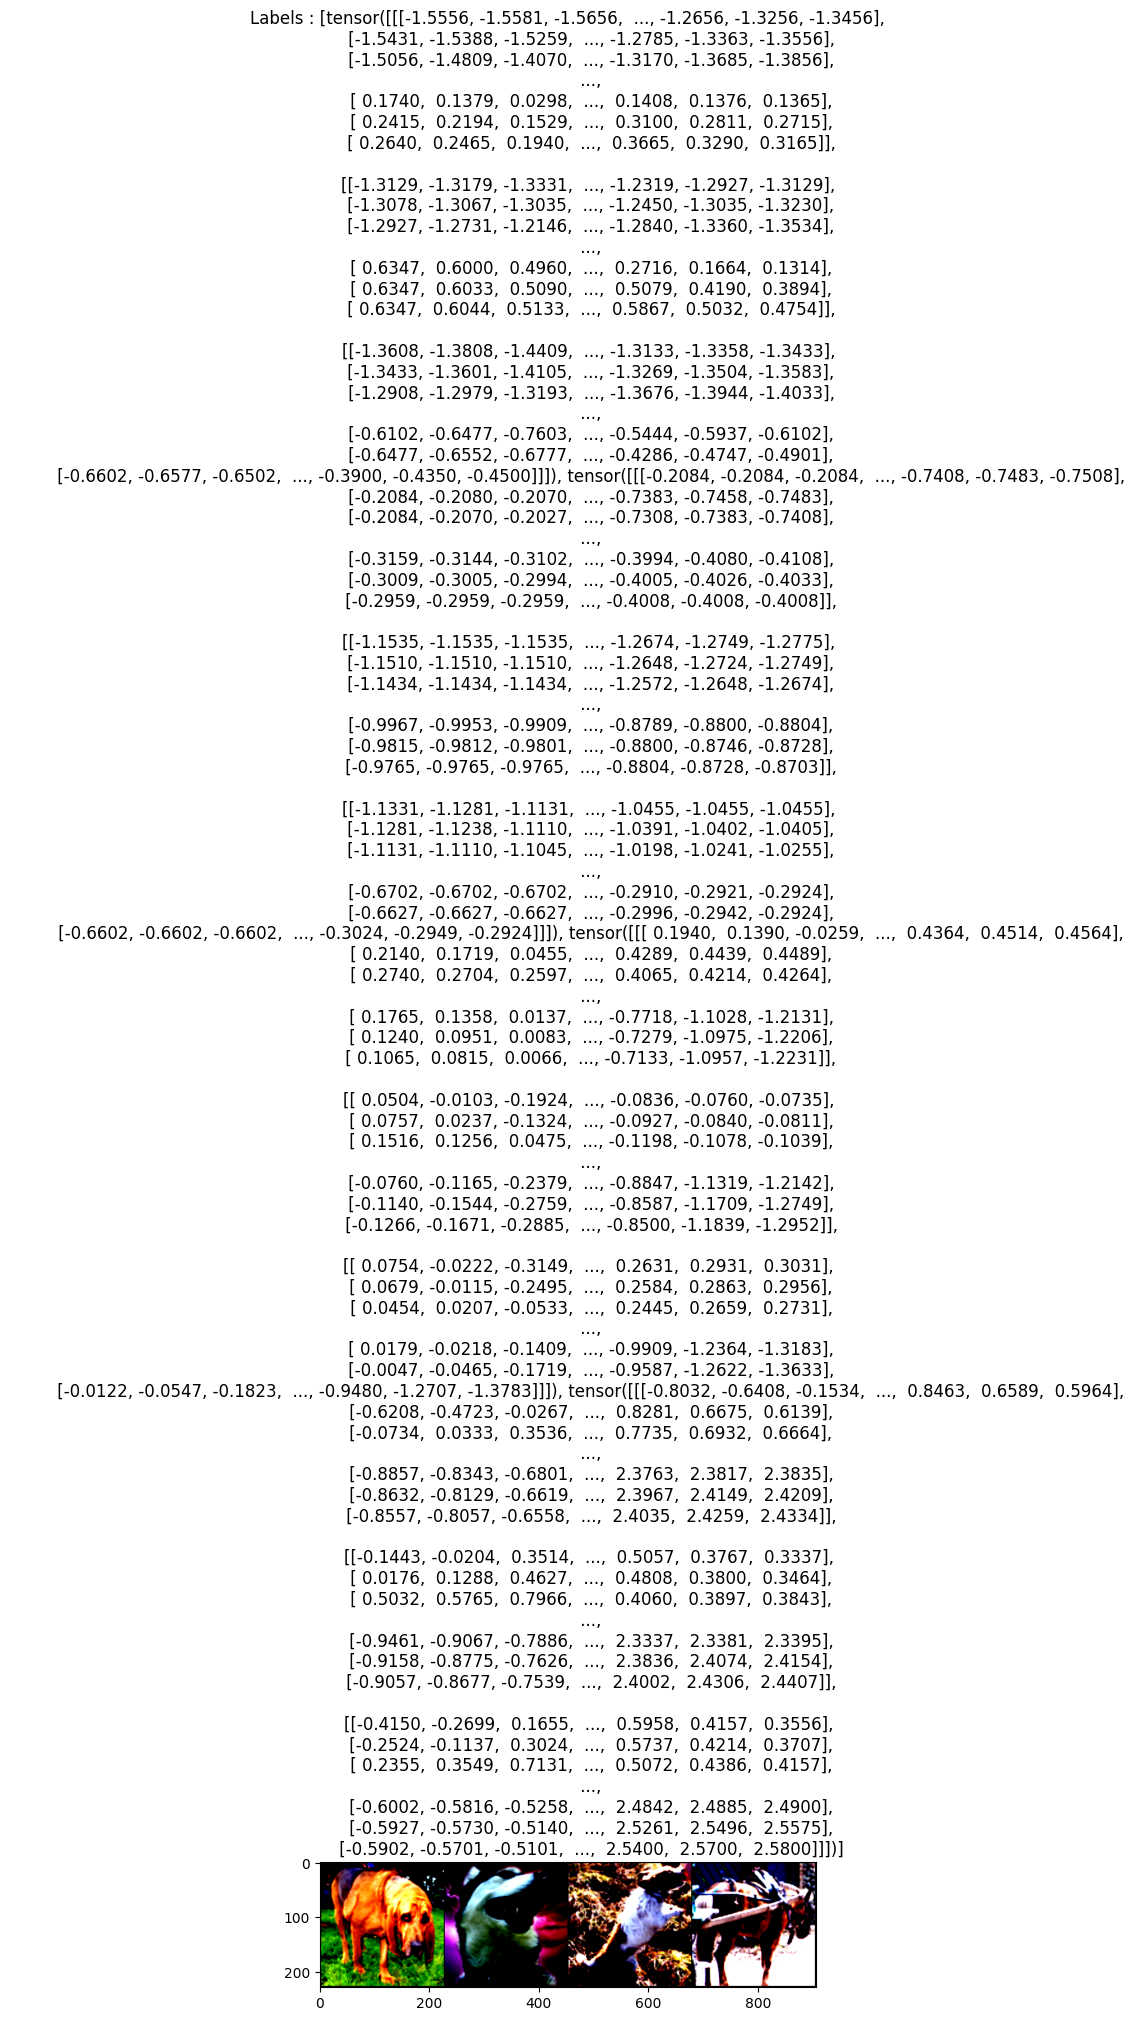

In [6]:
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    
    if y is not None:
        plt.title(f"Labels : {str(y)}")
        
np.random.seed(1)
torch.manual_seed(1)

grid_size = 4
rnd_inds = np.random.randint(0, len(train_dataset), grid_size)
print(f"image indices : {rnd_inds}")

x_grid = [train_dataset[i][0] for i in rnd_inds]
y_grid = [train_dataset[j][0] for j in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)

show(x_grid, y_grid)

In [8]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )
        
        self.shortcut = nn.Sequential()
        
        self.relu = nn.ReLU()
        
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x
    
    
class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )
        
        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU()
        
        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [14]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10, init_weights=True):
        super().__init__()
        
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        if init_weights:
            self._initialize_weights()
            
    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
    
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def restnet34():
    return ResNet(BasicBlock, [3,4,6,3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3,4,23,3])

def resnet152():
    return ResNet(BottleNeck, [3,8,36,3])

In [28]:
device = torch.device('mps')
model = resnet50().to(device)
x = torch.randn(3, 3, 224, 224).to(device)
output = model(x)
print(output.size())

torch.Size([3, 10])


In [30]:
summary(model.cpu(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [32]:
model = model.to(device)
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=0.0001)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

In [33]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [35]:
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metric_batch(output, target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    return loss.item(), metric_b

In [36]:
def loss_epoch(model, loss_func, dataset_dataloader, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dataloader.dataset)
    
    for xb, yb in dataset_dataloader:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)
        
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b
            
        if sanity_check is True:
            break
        
    loss = running_loss / len_data
    metric = running_metric / len_data
    
    return loss, metric

In [37]:
def train_val(model, params):
    num_epochs = params['num_epochs']
    loss_func = params['loss_func']
    opt = params['optimizer']
    train_dataloader = params['train_dataloader']
    valid_dataloader = params['valid_dataloader']
    sanity_check = params['sanity_check']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']
    
    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}
    
    best_loss  = float('inf')
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print(f"Epoch {epoch} / {num_epochs -1}, current lr : {current_lr}")
        
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dataloader, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, valid_dataloader, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)
        
        if val_loss < best_loss:
            best_loss = val_loss
            print("Get best weights")
            
        lsr_scheduler.step(val_loss)
        
        print(f'train loss : {train_loss:.6f}, val loss : {val_loss:.6f}, accuracy: {100*val_metric:.2f}%, time : {(time.time() - start_time) / 60:.4f} min')
        print('-'*10)
        
    return model, loss_history, metric_history

In [38]:
params_train = {
    'num_epochs' : 10,
    'optimizer' : opt,
    'loss_func' : loss_func,
    'train_dataloader' : train_dataloader,
    'valid_dataloader' : valid_dataloader,
    'sanity_check' : False,
    'lr_scheduler' : lr_scheduler,
    'path2weights' : './models/weights.pt',
}

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')

createFolder('./models')

In [39]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0 / 9, current lr : 0.0001


KeyboardInterrupt: 

In [ ]:
num_epochs = params_train['num_epochs']

plt.title("Train-Val Loss")
plt.plot(range(1, num_epochs+1), loss_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), loss_hist["val"], label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

plt.title("Train-Val Accuracy")
plt.plot(range(1, num_epochs+1), metric_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), metric_hist["val"], label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legent()
plt.show()